# 🌡️ Análise de Anomalias de Temperatura Global

## O que são Anomalias de Temperatura?

**Anomalias de temperatura** são desvios da temperatura média de um período de referência. Neste dataset, o **período base é 1951-1980**.

### Por que usar anomalias em vez de temperatura absoluta?

1. **Reduz variabilidade local**: Diferentes regiões têm climas muito diferentes. Uma anomalia de +2°C significa aquecimento relativo em qualquer local.

2. **Facilita comparações**: É mais fácil comparar tendências entre regiões usando desvios da média local.

3. **Melhor para análise de tendências**: Anomalias revelam mudanças climáticas de longo prazo de forma mais clara.

4. **Reduz ruído de dados**: Estações com dados incompletos têm menos impacto quando usamos anomalias.

## 1. Importação de Bibliotecas

In [199]:
!pip install pingouin
!pip install lets_plot

In [238]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import pingouin as pg
import requests
from lets_plot import *
from matplotlib.ticker import MultipleLocator
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson

LetsPlot.setup_html(no_js=True)

plt.style.use(
    "https://raw.githubusercontent.com/aeturrell/core_python/main/plot_style.txt"
)

## 2. Carregamento e Preparação dos Dados

In [201]:
df = (
    pd.read_csv(
        "/content/GLB.Ts+dSST.csv",
        skiprows=1,
        na_values="***"
    )
    .rename(columns={
        "Year": "Ano",
        "J-D": "anomalia_anual"
    })
    .set_index('Ano')
)

df.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,anomalia_anual,D-N,DJF,MAM,JJA,SON
Ano,,,,,,,,,,,,,,,,,,
1880,-0.19,-0.25,-0.10,-0.17,-0.11,-0.22,-0.19,-0.11,-0.15,-0.24,-0.23,-0.18,-0.18,NaN,NaN,-0.13,-0.17,-0.21
1881,-0.20,-0.15,0.03,0.04,0.05,-0.19,0.00,-0.04,-0.16,-0.22,-0.19,-0.07,-0.09,-0.10,-0.18,0.04,-0.08,-0.19
1882,0.15,0.13,0.04,-0.17,-0.15,-0.23,-0.17,-0.08,-0.15,-0.24,-0.17,-0.36,-0.12,-0.09,0.07,-0.09,-0.16,-0.19
1883,-0.30,-0.37,-0.13,-0.18,-0.17,-0.08,-0.07,-0.14,-0.21,-0.11,-0.23,-0.11,-0.18,-0.20,-0.34,-0.16,-0.10,-0.19
1884,-0.13,-0.08,-0.36,-0.41,-0.34,-0.36,-0.30,-0.27,-0.27,-0.25,-0.34,-0.31,-0.29,-0.27,-0.11,-0.37,-0.31,-0.29


In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, 1880 to 2025
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Jan             146 non-null    float64
 1   Feb             146 non-null    float64
 2   Mar             146 non-null    float64
 3   Apr             146 non-null    float64
 4   May             146 non-null    float64
 5   Jun             146 non-null    float64
 6   Jul             146 non-null    float64
 7   Aug             146 non-null    float64
 8   Sep             146 non-null    float64
 9   Oct             146 non-null    float64
 10  Nov             146 non-null    float64
 11  Dec             146 non-null    float64
 12  anomalia_anual  146 non-null    float64
 13  D-N             145 non-null    float64
 14  DJF             145 non-null    float64
 15  MAM             146 non-null    float64
 16  JJA             146 non-null    float64
 17  SON             146 non-null    floa

## 3. Análise Exploratória

In [203]:
print("Estatísticas das Anomalias de Temperatura (°C):")
df.describe().drop('count').rename(index={
    'mean': 'Média',
    'std': 'Desvio Padrão',
    'min': 'Mínimo',
    '25%': '25%',
    '50%': 'Mediana',
    '75%': '75%',
    'max': 'Máximo'
}).round(3)

Estatísticas das Anomalias de Temperatura (°C):


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,anomalia_anual,D-N,DJF,MAM,JJA,SON
Média,0.078,0.085,0.104,0.076,0.065,0.053,0.077,0.077,0.083,0.107,0.100,0.073,0.082,0.082,0.078,0.081,0.069,0.097
Desvio Padrão,0.447,0.452,0.458,0.420,0.397,0.396,0.379,0.397,0.399,0.403,0.412,0.426,0.402,0.403,0.431,0.421,0.387,0.400
Mínimo,-0.810,-0.630,-0.640,-0.600,-0.560,-0.520,-0.520,-0.550,-0.580,-0.580,-0.570,-0.820,-0.490,-0.500,-0.680,-0.580,-0.500,-0.520
25%,-0.248,-0.230,-0.230,-0.250,-0.240,-0.248,-0.190,-0.218,-0.190,-0.198,-0.178,-0.218,-0.200,-0.220,-0.230,-0.258,-0.218,-0.190
Mediana,-0.010,-0.035,0.015,-0.015,-0.035,-0.050,-0.030,-0.040,-0.055,0.010,0.020,-0.040,-0.030,-0.040,-0.030,-0.015,-0.040,-0.015
75%,0.320,0.398,0.352,0.298,0.280,0.268,0.290,0.305,0.272,0.268,0.288,0.358,0.318,0.300,0.370,0.310,0.310,0.280
Máximo,1.380,1.440,1.390,1.310,1.150,1.200,1.200,1.290,1.480,1.340,1.400,1.370,1.280,1.290,1.360,1.280,1.230,1.410


In [204]:
print(f"Anomalia média: {df['anomalia_anual'].mean():.3f}°C")
print(f"Aquecimento total: {df['anomalia_anual'].iloc[-1] - df['anomalia_anual'].iloc[0]:.2f}°C")
print(f"Ano mais quente: {df['anomalia_anual'].idxmax()} ({df['anomalia_anual'].max():.2f}°C)")
print(f"Anos acima de +1°C: {(df['anomalia_anual'] > 1.0).sum()} anos")

Anomalia média: 0.082°C
Aquecimento total: 1.37°C
Ano mais quente: 2024 (1.28°C)
Anos acima de +1°C: 5 anos


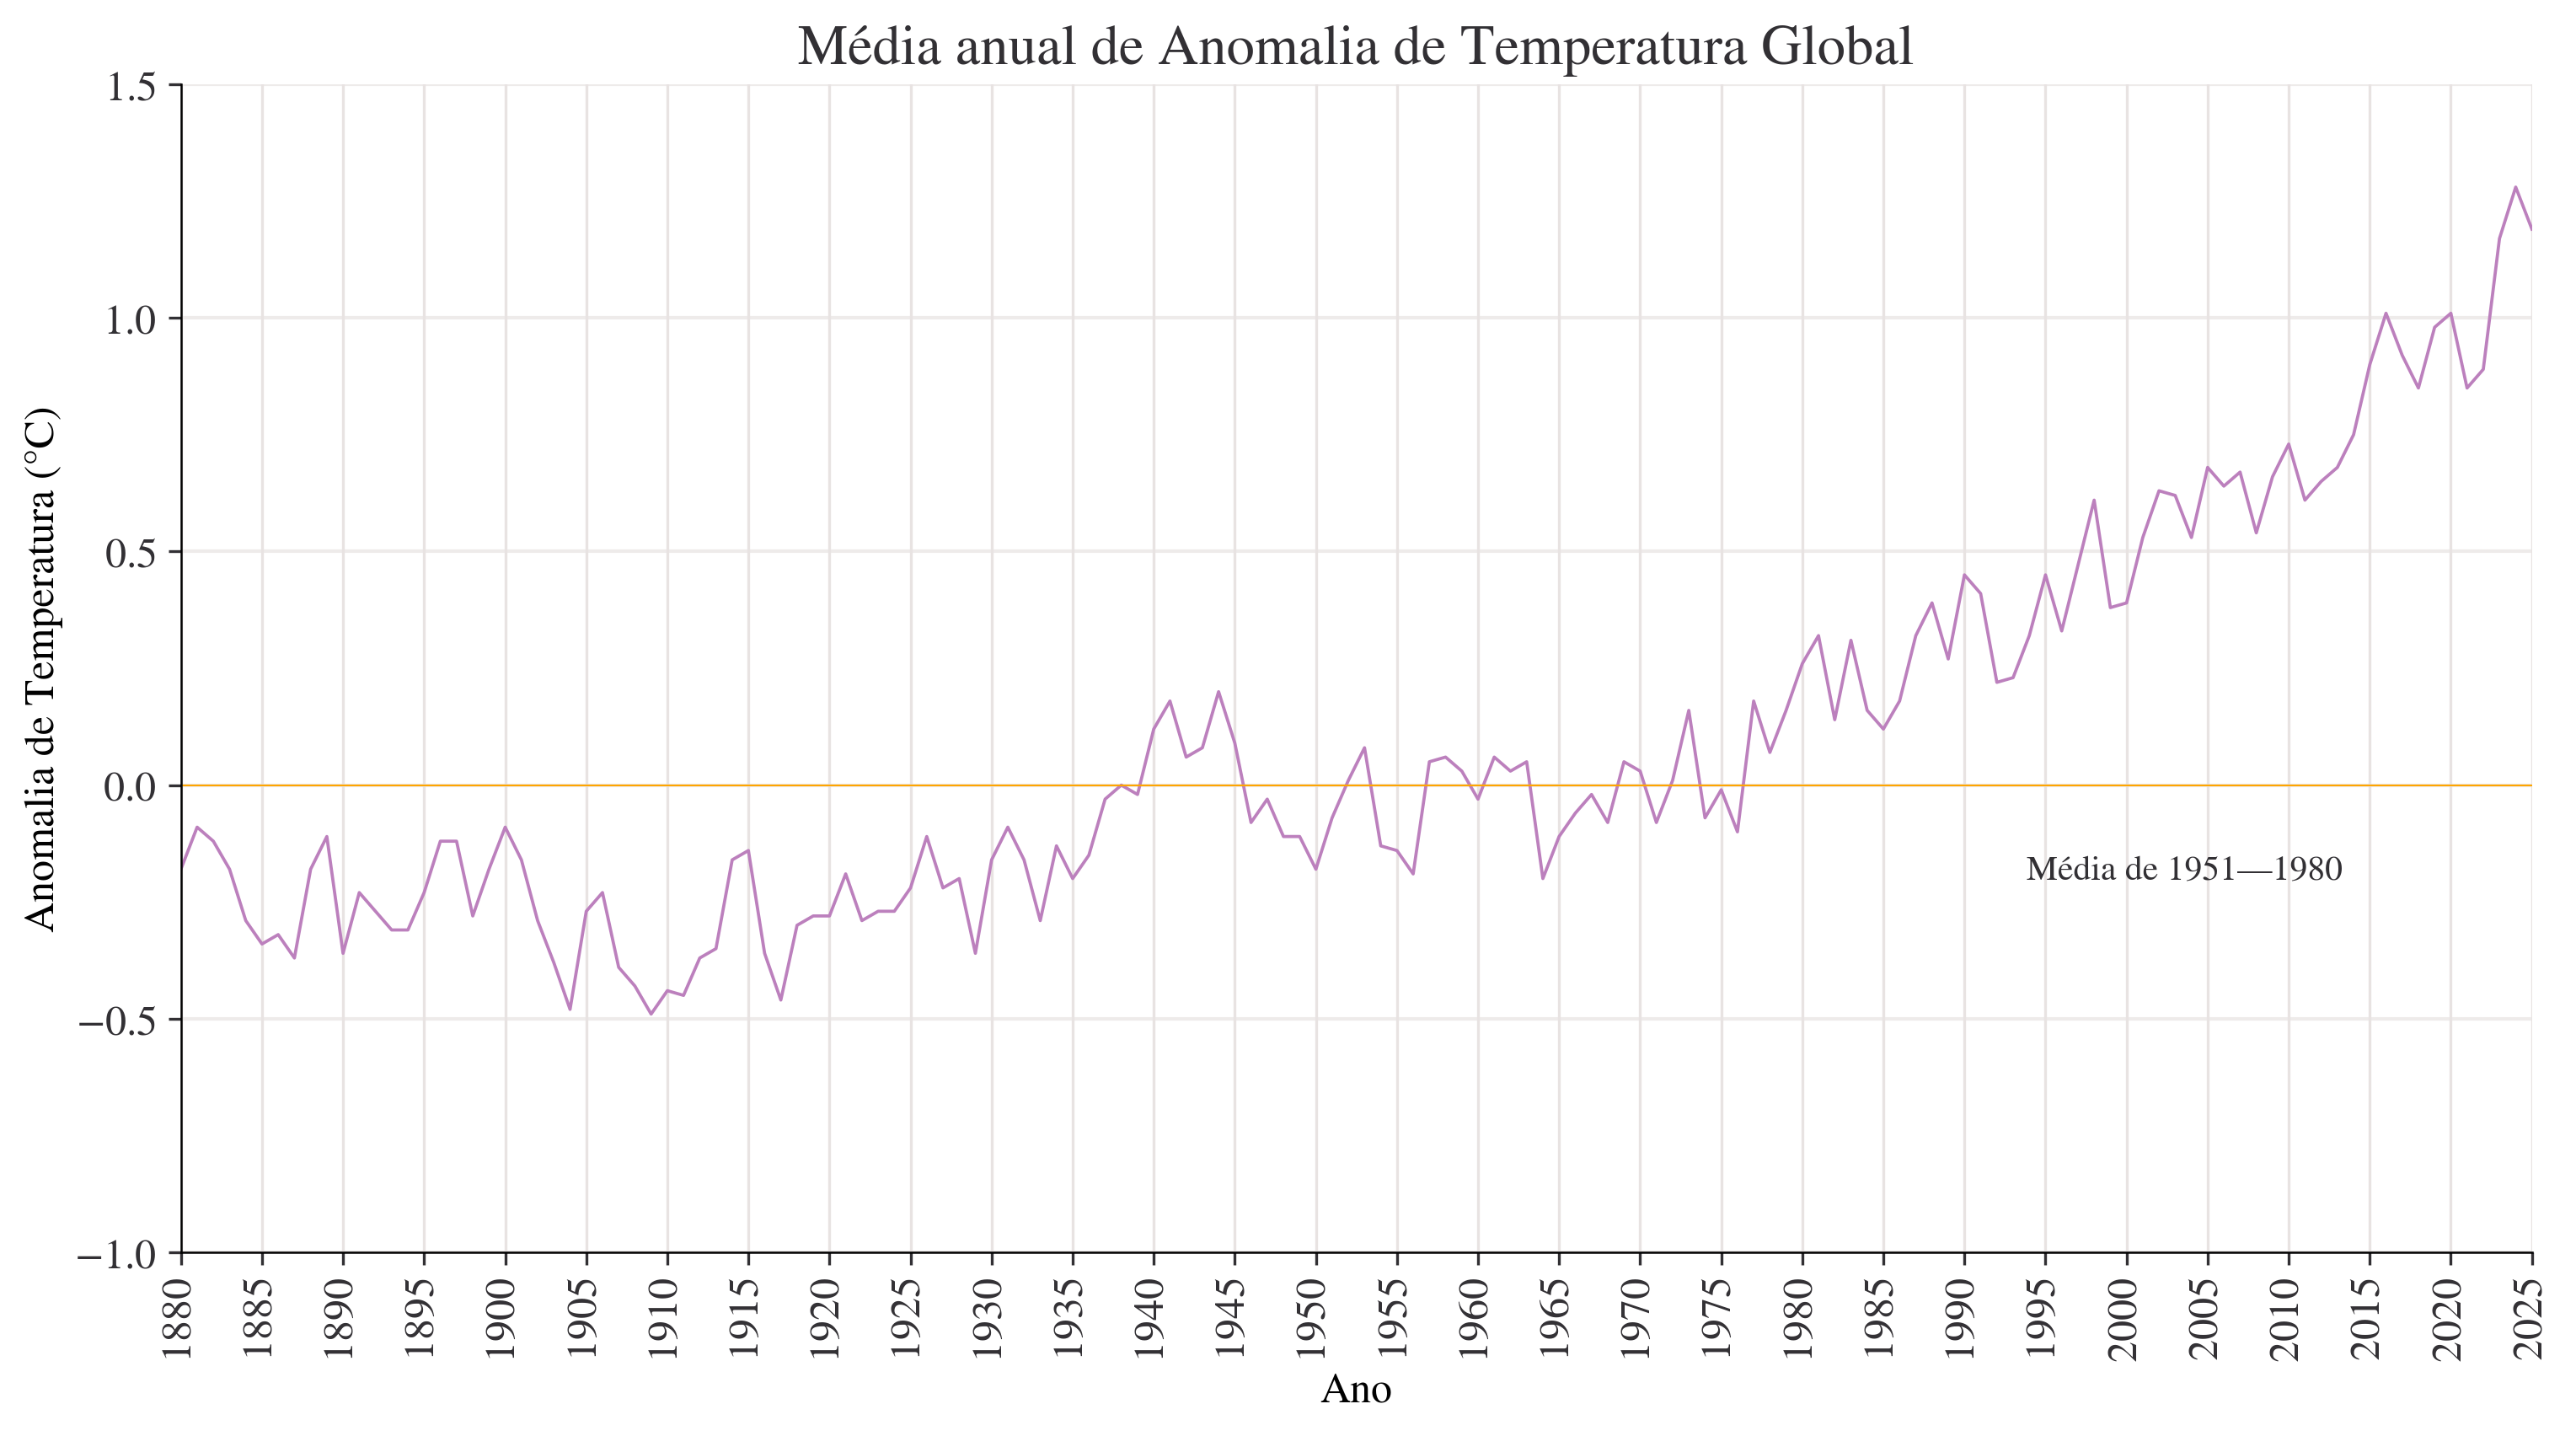

In [205]:
fig, ax = plt.subplots(figsize=(12,6))
df["anomalia_anual"].plot(ax=ax, linewidth = 0.9)
ax.set_ylabel("Anomalia de Temperatura (°C)")
ax.set_xlabel("Ano")

ax.axhline(0, color="orange", linewidth = 0.5)
ax.annotate("Média de 1951—1980", xy=(0.668, -0.2), xycoords=("figure fraction", "data"))

ax.set_title("Média anual de Anomalia de Temperatura Global", loc="center")
ax.set_xlim(df.index.min(), df.index.max())

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.set_ylim(-1, 1.5)
ax.grid(True, alpha=0.7, linewidth=1, axis='y')

plt.xticks(rotation=90)

plt.show()

In [206]:
df["periodo"] = pd.cut(
    df.index,
    bins=[1880,1921, 1950, 1980, 2010, 2025],
    labels=["1880—1921", "1921—1950", "1951—1980", "1981—2010", "2011—2025"],
    ordered=True,
)
df["periodo"].tail(20)

estatisticas_periodos = df.groupby('periodo', observed = True)['anomalia_anual'].agg([
    ('Média', 'mean'),
    ('Mediana', 'median'),
    ('Desvio Padrão', 'std'),
    ('Mínimo', 'min'),
    ('Máximo', 'max')
]).round(3)

print("Estatísticas por Período (Anomalia Anual):")
print(estatisticas_periodos)

Estatísticas por Período (Anomalia Anual):
           Média  Mediana  Desvio Padrão  Mínimo  Máximo
periodo                                                 
1880—1921 -0.278    -0.28          0.115   -0.49   -0.09
1921—1950 -0.102    -0.11          0.147   -0.36    0.20
1951—1980  0.000     0.01          0.109   -0.20    0.26
1981—2010  0.423     0.40          0.180    0.12    0.73
2011—2025  0.916     0.90          0.198    0.61    1.28


In [207]:
jja = ["Jun", "Jul", "Aug"]
df[jja].stack()

Ano      
1880  Jun   -0.22
      Jul   -0.19
      Aug   -0.11
1881  Jun   -0.19
      Jul    0.00
             ... 
2024  Jul    1.20
      Aug    1.29
2025  Jun    1.05
      Jul    1.02
      Aug    1.16
Length: 438, dtype: float64

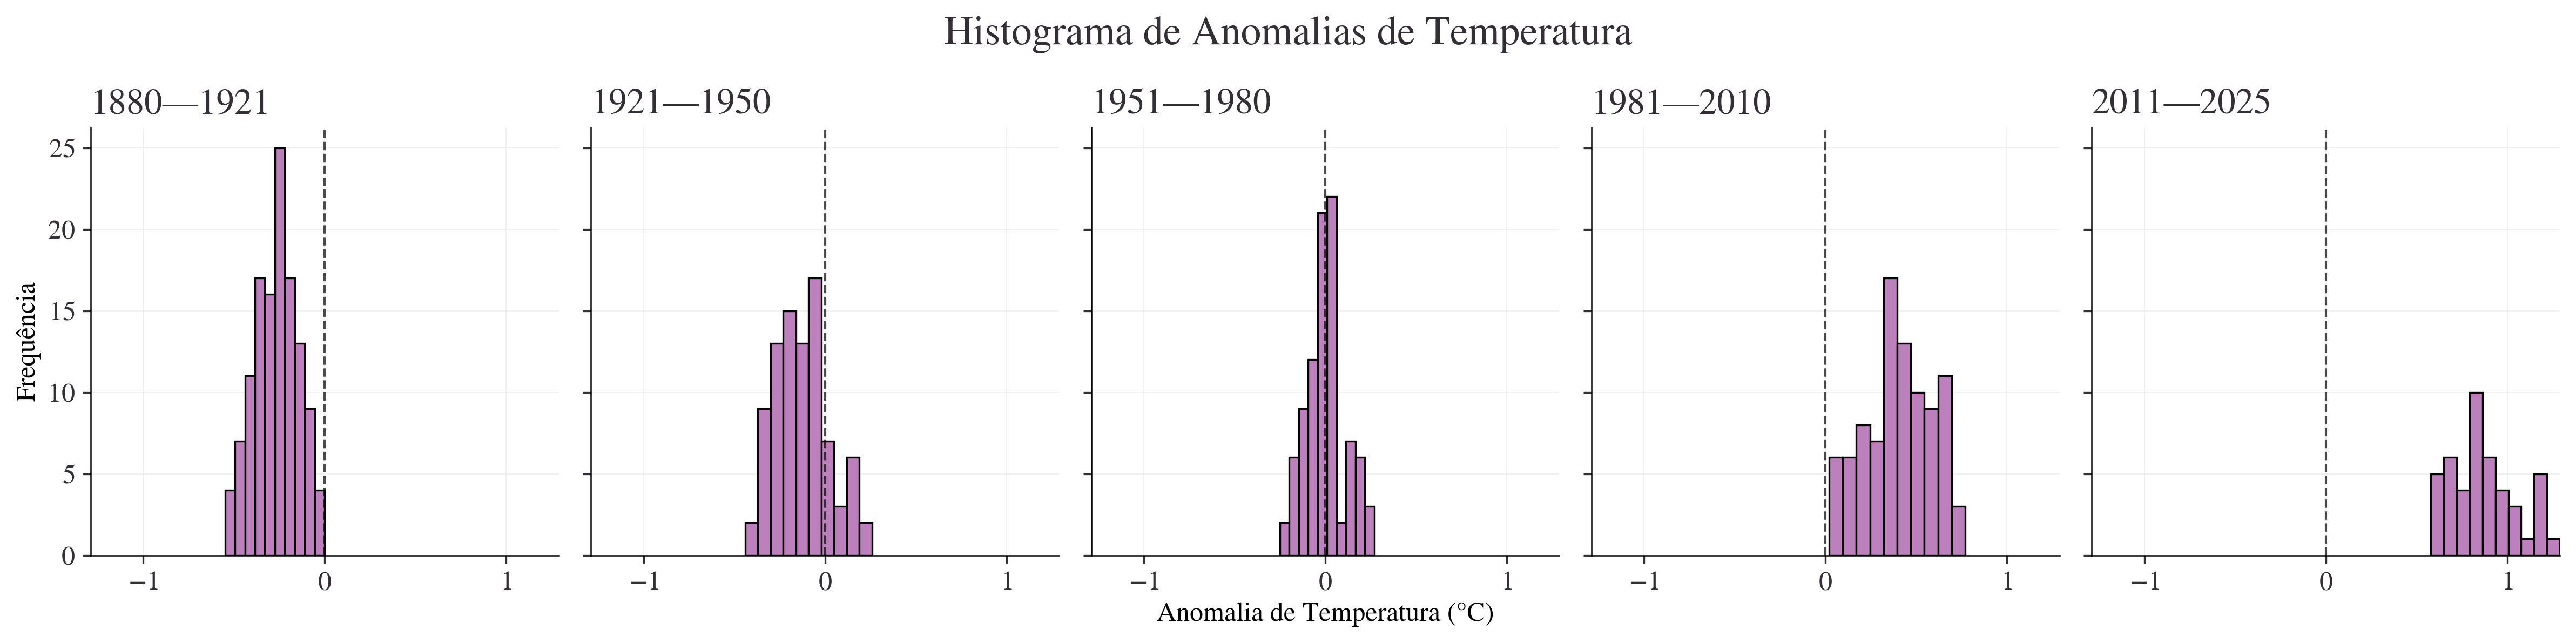

In [208]:
fig, axes = plt.subplots(ncols=5, figsize=(16, 4), sharex=True, sharey=True)

max_abs = max(abs(df[jja].min().min()), abs(df[jja].max().max()))

for ax, periodo in zip(axes, df["periodo"].dropna().unique()):
    df.loc[df["periodo"] == periodo, jja].stack().hist(
        ax=ax,
        edgecolor = 'black',
        linewidth = 0.8
        )
    ax.axvline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)

    ax.set_title(periodo)
    ax.grid(True, alpha=0.5, linewidth=0.5)
    ax.set_xlim(-max_abs, max_abs)


plt.suptitle("Histograma de Anomalias de Temperatura")
axes[2].set_xlabel('Anomalia de Temperatura (°C)', fontsize=12)
axes[0].set_ylabel('Frequência', fontsize=12)

plt.tight_layout();

In [209]:
temp_meses = df.loc[(df.index >= 1951) & (df.index <= 1980), "Jan":"Dec"]

temp_meses = (
    temp_meses.stack()
    .reset_index()
    .rename(columns={"level_1": "mês", 0: "valores"})
)
print(temp_meses)

quartis = [0.3, 0.7]
percentis = np.quantile(temp_meses["valores"], q=quartis)

print(f"O limite inferior de {quartis[0]*100}% é {percentis[0]:.2f}")
print(f"O limite superior de {quartis[1]*100}% é {percentis[1]:.2f}")

      Ano  mês  valores
0    1951  Jan    -0.34
1    1951  Feb    -0.41
2    1951  Mar    -0.20
3    1951  Apr    -0.14
4    1951  May     0.00
..    ...  ...      ...
355  1980  Aug     0.18
356  1980  Sep     0.20
357  1980  Oct     0.13
358  1980  Nov     0.29
359  1980  Dec     0.21

[360 rows x 3 columns]
O limite inferior de 30.0% é -0.07
O limite superior de 70.0% é 0.07


In [210]:
temp_meses = df.loc[(df.index >= 1981) & (df.index <= 2010), "Jan":"Dec"]

temp_meses = (
    temp_meses.stack()
    .reset_index()
    .rename(columns={"level_1": "mês", 0: "valores"})
)

print(temp_meses)

      Ano  mês  valores
0    1981  Jan     0.53
1    1981  Feb     0.42
2    1981  Mar     0.48
3    1981  Apr     0.32
4    1981  May     0.24
..    ...  ...      ...
355  2010  Aug     0.67
356  2010  Sep     0.63
357  2010  Oct     0.71
358  2010  Nov     0.82
359  2010  Dec     0.45

[360 rows x 3 columns]


## 3.2 Análise de Correlação

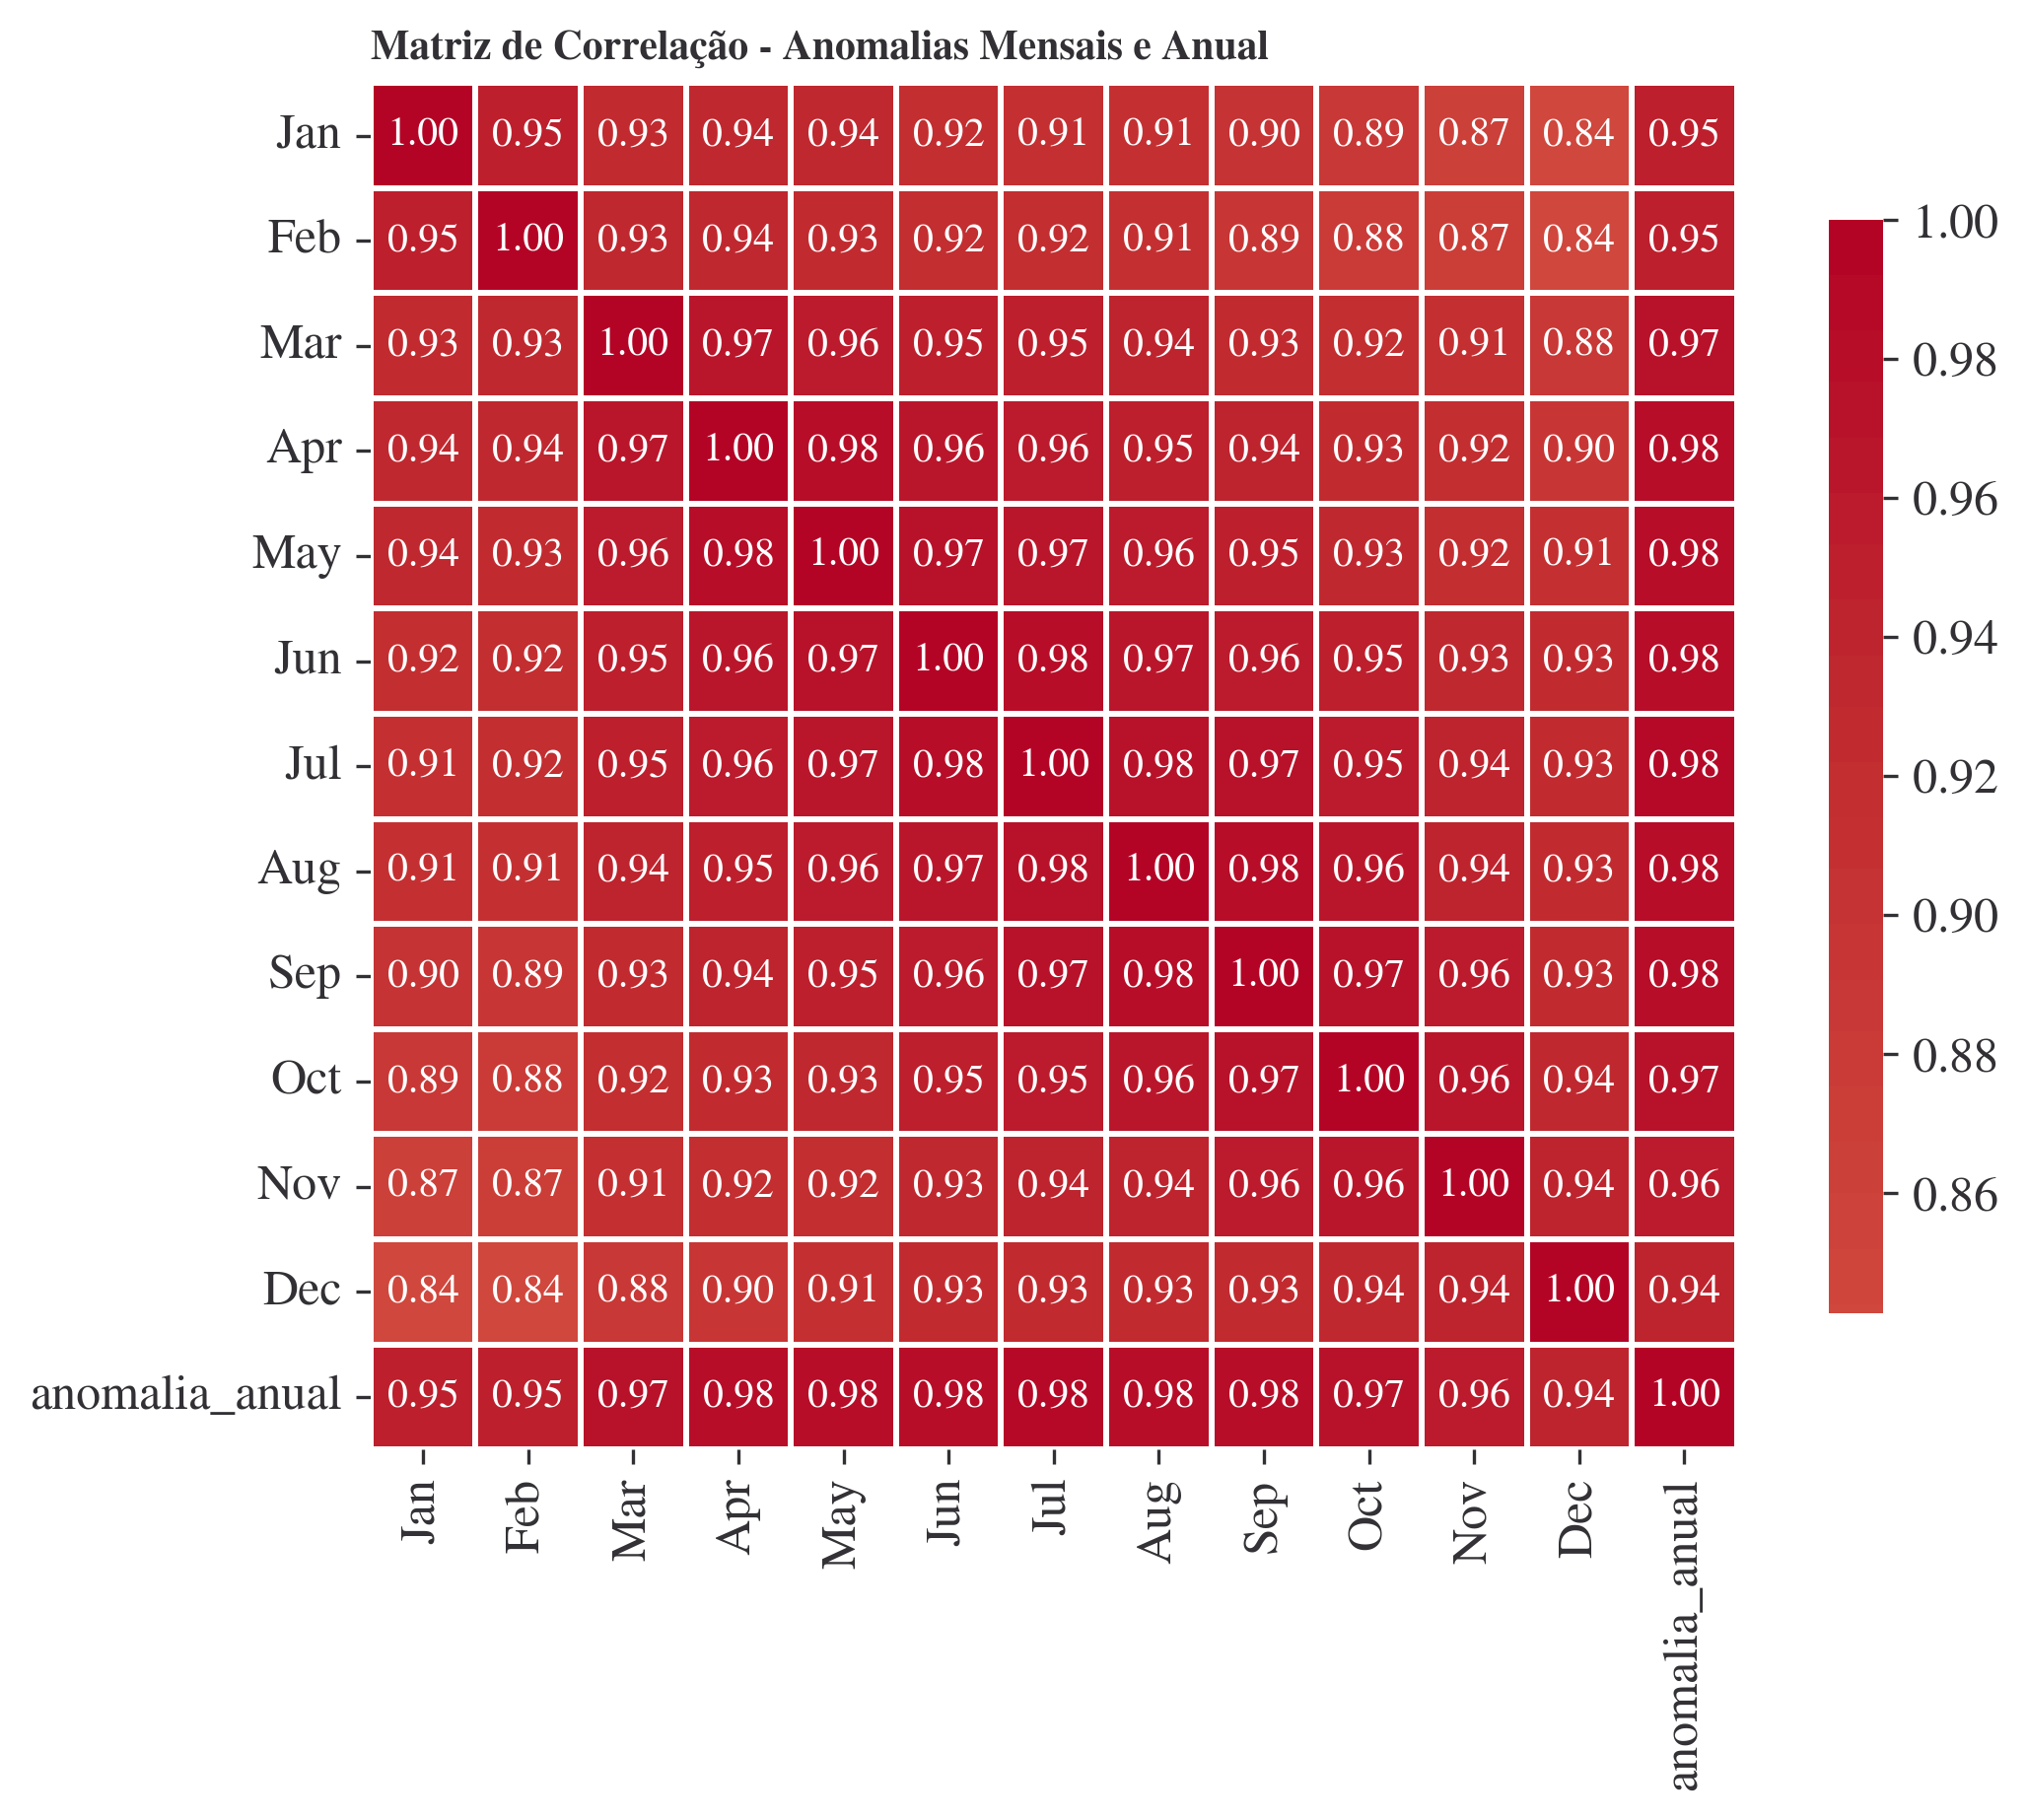

Meses mais correlacionados com anomalia anual:
  • Jul: r = 0.984
  • Jun: r = 0.983
  • Aug: r = 0.982
  • May: r = 0.982
  • Apr: r = 0.979


In [211]:
colunas_analise = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'anomalia_anual']

correlacao = df[colunas_analise].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(correlacao, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            ax=ax)
ax.set_title('Matriz de Correlação - Anomalias Mensais e Anual',
             fontsize=10, fontweight='bold')
plt.show()


print("Meses mais correlacionados com anomalia anual:")
corr_anual = correlacao['anomalia_anual'].drop('anomalia_anual').sort_values(ascending=False)
for mes, valor in corr_anual.head(5).items():
    print(f"  • {mes}: r = {valor:.3f}")

In [212]:
print(f"O limite inferior de {quartis[0]*100}% é {percentis[0]:.2f}")
print(f"O limite superior de {quartis[1]*100}% é {percentis[1]:.2f}")

O limite inferior de 30.0% é -0.07
O limite superior de 70.0% é 0.07


In [213]:
entradas_q30 = temp_meses["valores"] < percentis[0]
proporcao_q30 = entradas_q30.mean()
print(
    f"A proporção abaixo de {percentis[0]:.2f} é {proporcao_q30*100:.2f}%"
)

proporcao_q70 = (temp_meses ["valores"] > percentis[1]).mean()
print(f"A proporção acima de {percentis[1]} é {proporcao_q70*100:.2f}%")

A proporção abaixo de -0.07 é 0.00%
A proporção acima de 0.07 é 95.28%


In [214]:
temp_meses = (
    df.loc[:, "DJF":"SON"]
    .stack()
    .reset_index()
    .rename(columns={"level_1": "Trimestre", 0: "Valores"})
)
temp_meses["periodo"] = pd.cut(
    temp_meses["Ano"],
    bins=[1921, 1950, 1980, 2010, 2025],
    labels=["1921-1950", "1951-1980", "1981-2010","2011-2025"],
    ordered=True,
)

temp_meses.tail()

,Ano,Trimestre,Valores,periodo
578,2024,SON,1.29,2011-2025
579,2025,DJF,1.30,2011-2025
580,2025,MAM,1.22,2011-2025
581,2025,JJA,1.08,2011-2025
582,2025,SON,1.22,2011-2025


In [215]:
grp_mean_var = (
    temp_meses.groupby(["Trimestre", "periodo"], observed=False)["Valores"]
    .agg(["mean", "var"])
    .rename(columns={"mean": "média", "var": "variância"})
)

grp_mean_var

média  variância
Trimestre periodo                       
DJF       1921-1950 -0.100690   0.036350
          1951-1980 -0.005333   0.025384
          1981-2010  0.446000   0.037459
          2011-2025  0.904667   0.075470
JJA       1921-1950 -0.131724   0.022136
          1951-1980 -0.000333   0.009369
          1981-2010  0.400000   0.033248
          2011-2025  0.869333   0.031821
MAM       1921-1950 -0.119655   0.025675
          1951-1980 -0.000333   0.024590
          1981-2010  0.442667   0.033924
          2011-2025  0.930000   0.043971
SON       1921-1950 -0.055517   0.020318
          1951-1980 -0.001000   0.012285
          1981-2010  0.401000   0.047168
          2011-2025  0.947333   0.045992

In [216]:
min_ano = 1880
(
    ggplot(temp_meses, aes(x="Ano", y="Valores", color="Trimestre"))
    + geom_abline(slope=0, color="black", size=1)
    + geom_line(size=1)
    + labs(
        title=f"Anomalia de Temperatura Global ({min_ano}—{temp_meses['Ano'].max()})",
        x="Ano",
        y="Anomalia de Temperatura (°C)"
    )
    + scale_x_continuous(format="d")
    + geom_text(
        x=min_ano, y=0.1, label="Média 1951—1980 ", hjust="left", color="black"
    )
)

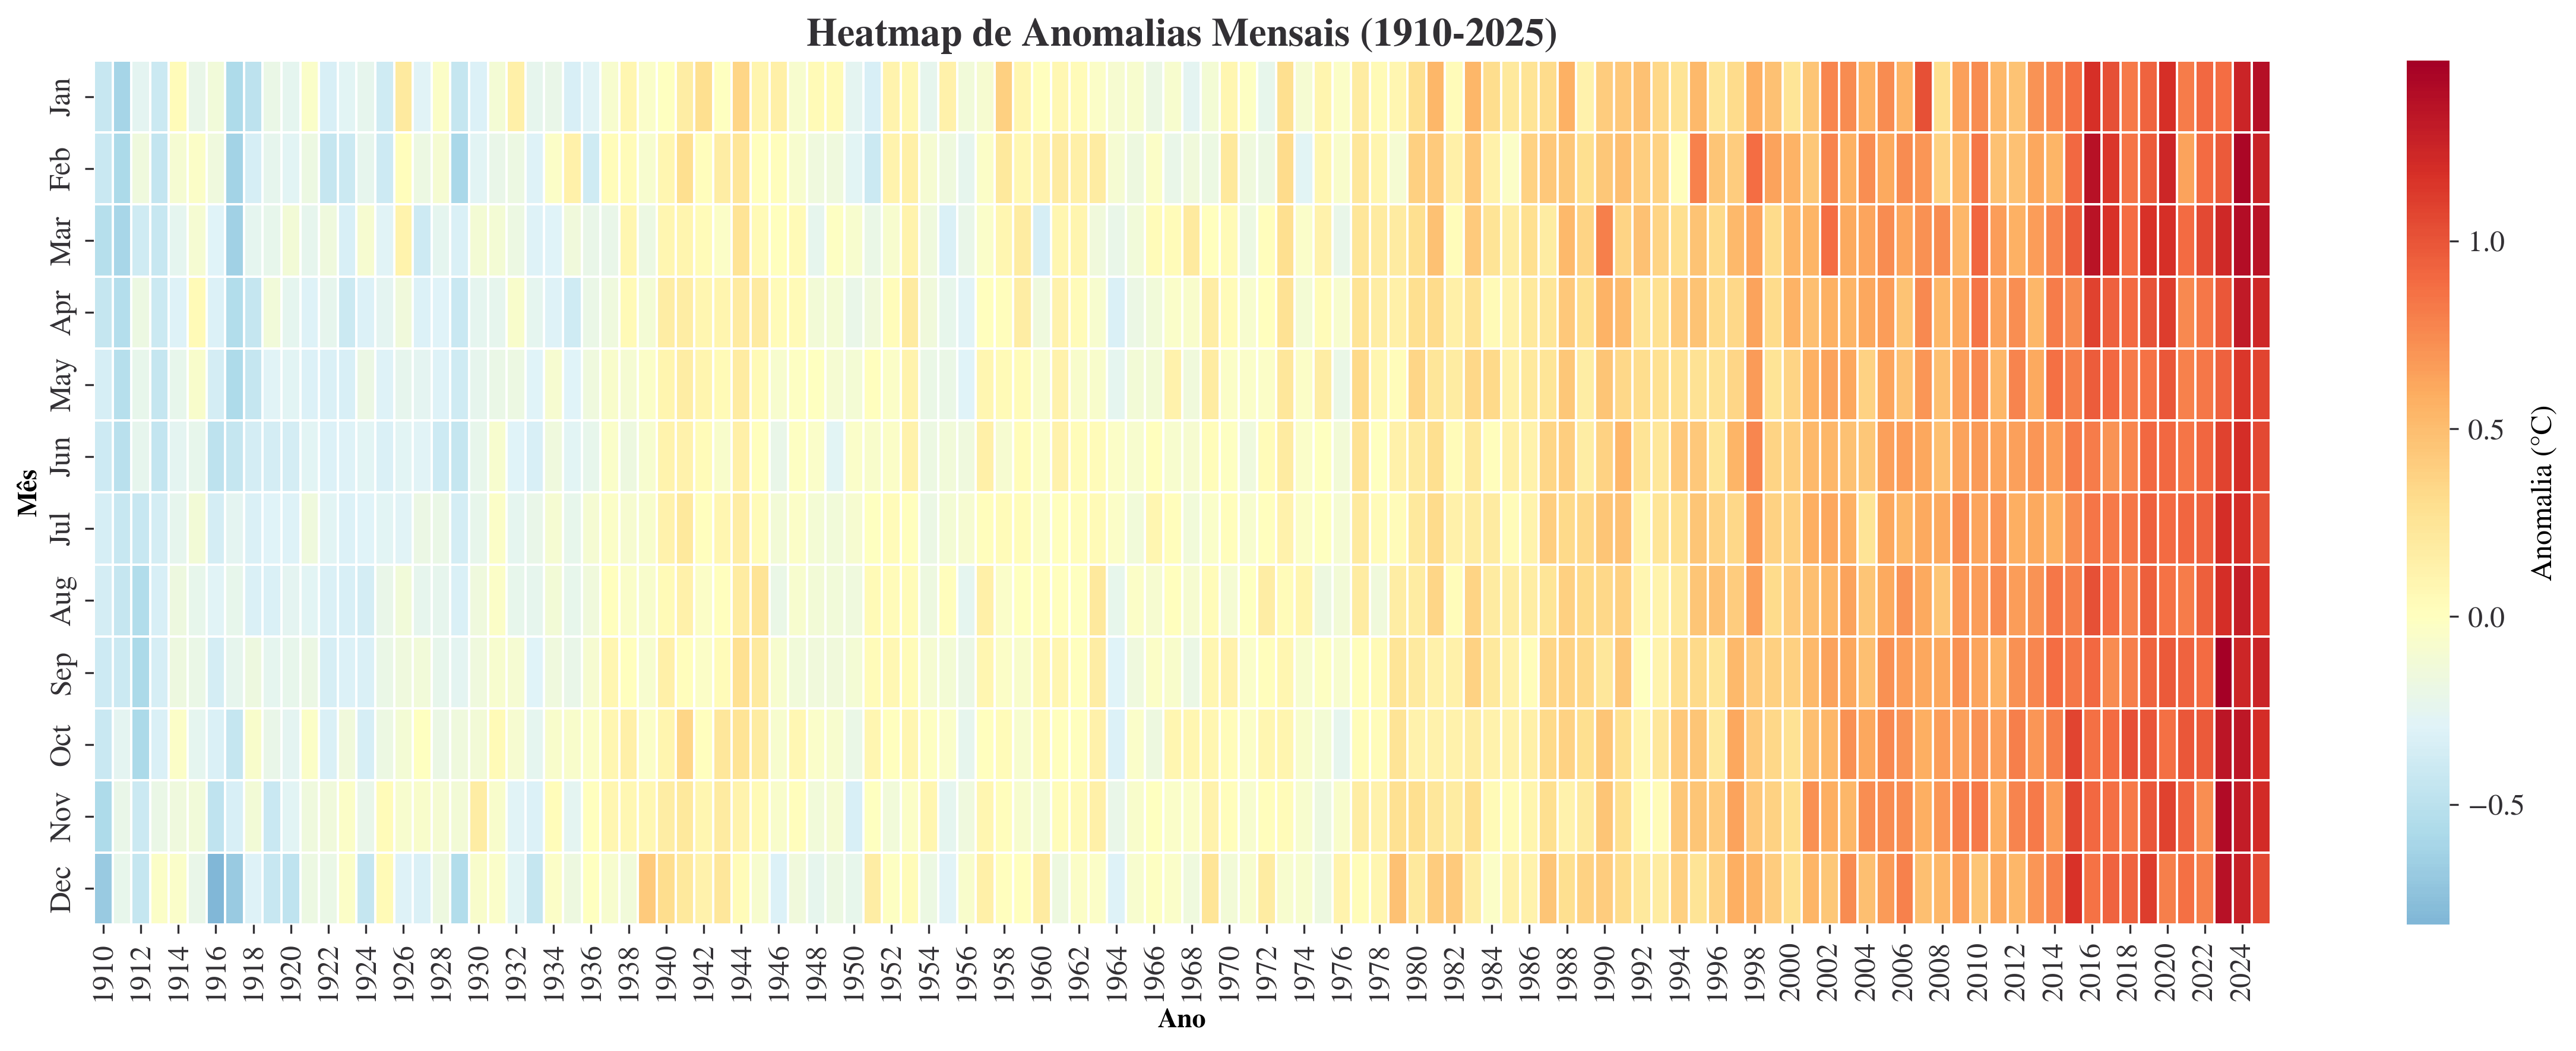

In [217]:
meses = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
dados_heatmap = df.loc[1910:, meses].T

fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(dados_heatmap, cmap='RdYlBu_r', center=0,
            cbar_kws={'label': 'Anomalia (°C)'},
            linewidths=0.5, ax=ax)

ax.set_title('Heatmap de Anomalias Mensais (1910-2025)',
             fontsize=16, fontweight='bold', loc ='center')
ax.set_xlabel('Ano', fontsize=11, fontweight='bold')
ax.set_ylabel('Mês', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Análise de CO²

In [226]:
df_co2 = (
    pd.read_csv(
        "https://ourworldindata.org/grapher/annual-co2-emissions-per-country.csv?v=1&csvType=full&useColumnShortNames=true",
        storage_options={'User-Agent': 'Our World In Data data fetch/1.0'}
    )
    .rename(columns={"year": "Ano", "entity": "paises", "emissions_total": "total_emissoes"})
    .drop('code', axis=1)
    .groupby('Ano')['total_emissoes'].sum()
    .div(1e9)
    .reset_index()
)
df_co2

,Ano,total_emissoes
0,1750,0.055836
1,1751,0.056443
2,1752,0.057031
3,1753,0.057663
4,1754,0.058401
...,...,...
270,2020,226.123155
271,2021,236.932334
272,2022,240.370224
273,2023,242.955626


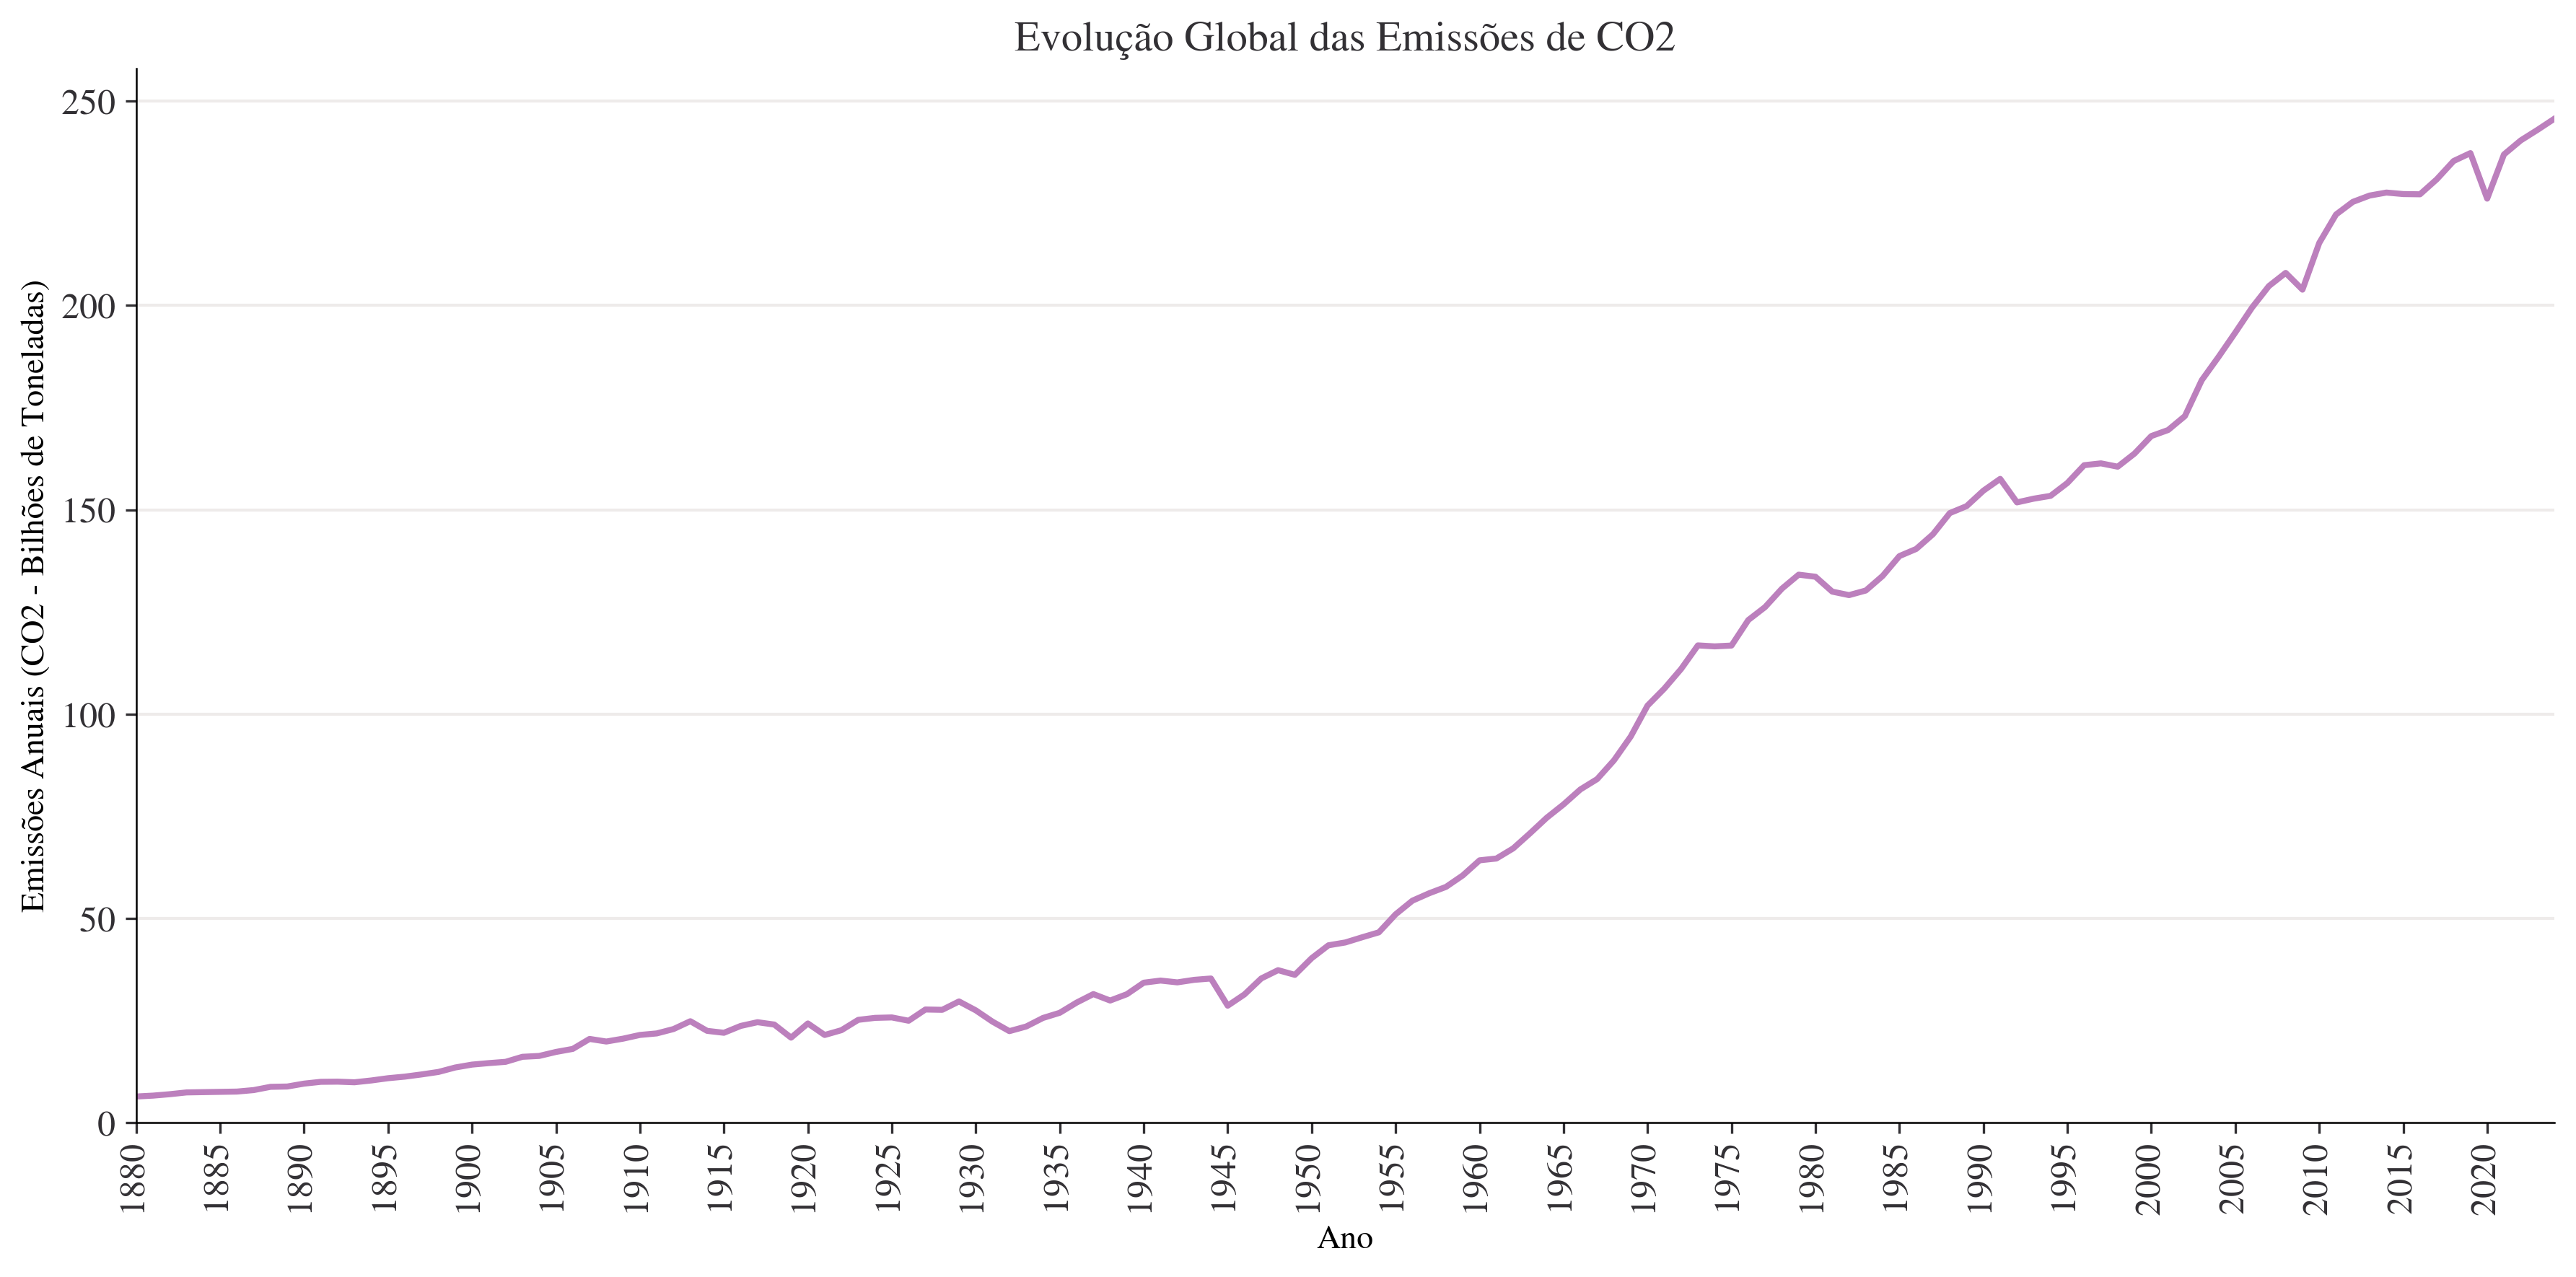

In [219]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(df_co2['Ano'], df_co2['total_emissoes'] / 1e9, linewidth=2)

ax.set_title("Evolução Global das Emissões de CO2", fontsize=14, loc="center")
ax.set_ylabel("Emissões Anuais (CO2 - Bilhões de Toneladas)", fontsize=11)
ax.set_xlabel("Ano", fontsize=11)


ax.set_xlim(1880, df_co2['Ano'].max())
ax.set_ylim(0, None)


ax.xaxis.set_major_locator(MultipleLocator(5))
ax.grid(True, alpha=0.7, linewidth=1, axis='y')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [227]:
df_temp_co2 = pd.merge(df_co2, df, on="Ano")
df_temp_co2[["Ano", "total_emissoes", "anomalia_anual"]].tail(10)

,Ano,total_emissoes,anomalia_anual
135,2015,227.241884,0.90
136,2016,227.186122,1.01
137,2017,230.859280,0.92
138,2018,235.325126,0.85
139,2019,237.264353,0.98
140,2020,226.123155,1.01
141,2021,236.932334,0.85
142,2022,240.370224,0.89
143,2023,242.955626,1.17
144,2024,245.672263,1.28


## 4.1 Regressão Linear

In [236]:
y = df_temp_co2['anomalia_anual']
X = df_temp_co2['total_emissoes']

X_com_constante = sm.add_constant(X)

modelo = sm.OLS(y, X_com_constante).fit()

print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:         anomalia_anual   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     910.4
Date:                Mon, 02 Feb 2026   Prob (F-statistic):           7.03e-64
Time:                        18:12:07   Log-Likelihood:                 75.018
No. Observations:                 145   AIC:                            -146.0
Df Residuals:                     143   BIC:                            -140.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.3308      0.018    -18.

/tmp/ipython-input-28880766.py:29: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) STIXGeneral.
  plt.tight_layout()


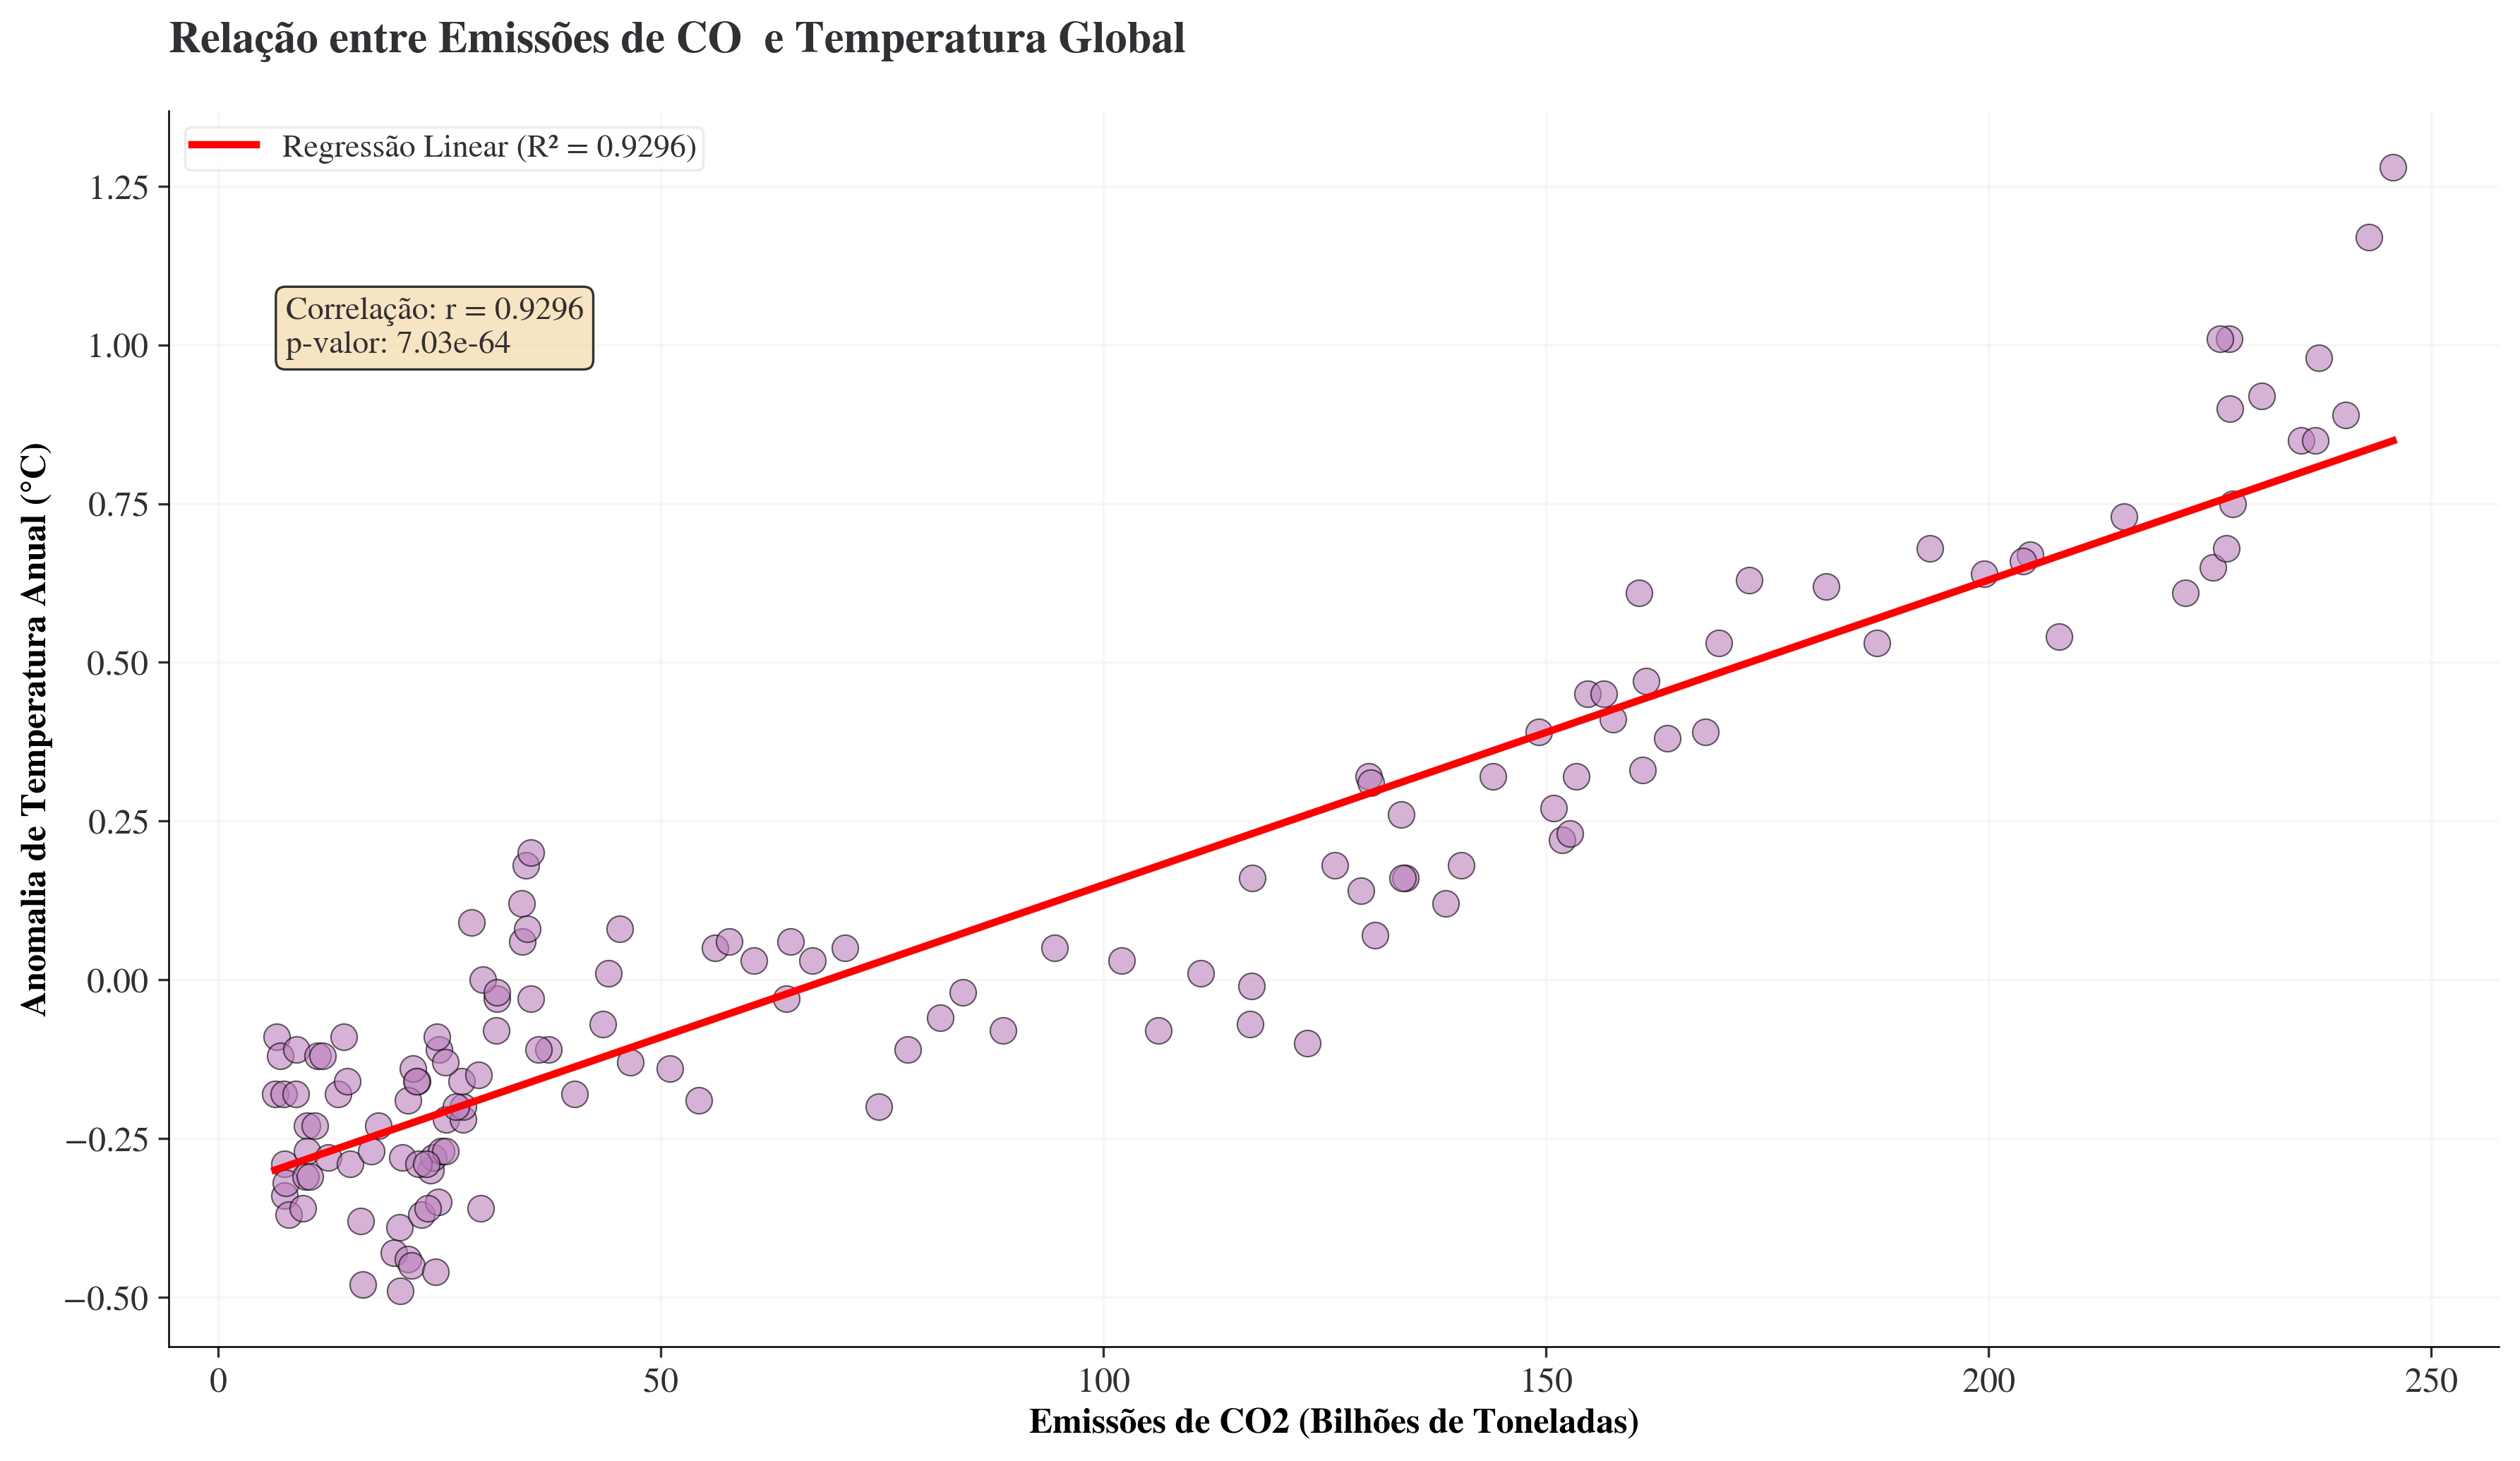

In [235]:
intercepto = modelo.params['const']
inclinacao = modelo.params['total_emissoes']
r2 = modelo.rsquared
p_valor = modelo.pvalues['total_emissoes']

r2 = df_temp_co2['total_emissoes'].corr(df_temp_co2['anomalia_anual'])

fig, ax = plt.subplots(figsize=(12, 7))

ax.scatter(X, y, alpha=0.6, s=80, edgecolor='black', linewidth=0.5)

x_linha = np.array([X.min(), X.max()])
y_linha = inclinacao * x_linha + intercepto

ax.plot(x_linha, y_linha, 'r-', linewidth=2.5,
        label=f'Regressão Linear (R² = {r2:.4f})')

ax.set_xlabel('Emissões de CO2 (Bilhões de Toneladas)', fontsize=12, fontweight='bold')
ax.set_ylabel('Anomalia de Temperatura Anual (°C)', fontsize=12, fontweight='bold')
ax.set_title('Relação entre Emissões de CO₂ e Temperatura Global',
             fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3)

textstr = f'Correlação: r = {r2:.4f}\np-valor: {p_valor:.2e}'
ax.text(0.05, 0.85, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

In [241]:
dw = durbin_watson(modelo.resid)
print(f"Durbin-Watson: {dw}")

# 2. Teste ADF para verificar estacionariedade
res_temp = adfuller(df['anomalia_anual'])
print(f"P-valor ADF Temperatura: {res_temp[1]}")

Durbin-Watson: 0.6269348355507666
P-valor ADF Temperatura: 0.9984673978614922


In [248]:
# Criando as primeiras diferenças (o 'delta')
df_temp_co2['diff_temp'] = df_temp_co2['anomalia_anual'].diff()
df_temp_co2['diff_co2'] = df_temp_co2['total_emissoes'].diff()

# Removendo o primeiro valor que será NaN
df_temp_co2_diff = df_temp_co2.dropna()

# Calculando a nova correlação
correlacao_real = df_temp_co2_diff['diff_temp'].corr(df_temp_co2_diff['diff_co2'])
print(f"Correlação nas diferenças: {correlacao_real:.2f}")

# Se quiser rodar a nova regressão:
modelo_diff = sm.OLS(df_temp_co2_diff['diff_temp'], sm.add_constant(df_temp_co2_diff['diff_co2'])).fit()
print(modelo_diff.summary())

Correlação nas diferenças: -0.07
                            OLS Regression Results                            
Dep. Variable:              diff_temp   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.6934
Date:                Mon, 02 Feb 2026   Prob (F-statistic):              0.406
Time:                        18:29:10   Log-Likelihood:                 110.26
No. Observations:                 144   AIC:                            -216.5
Df Residuals:                     142   BIC:                            -210.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.01

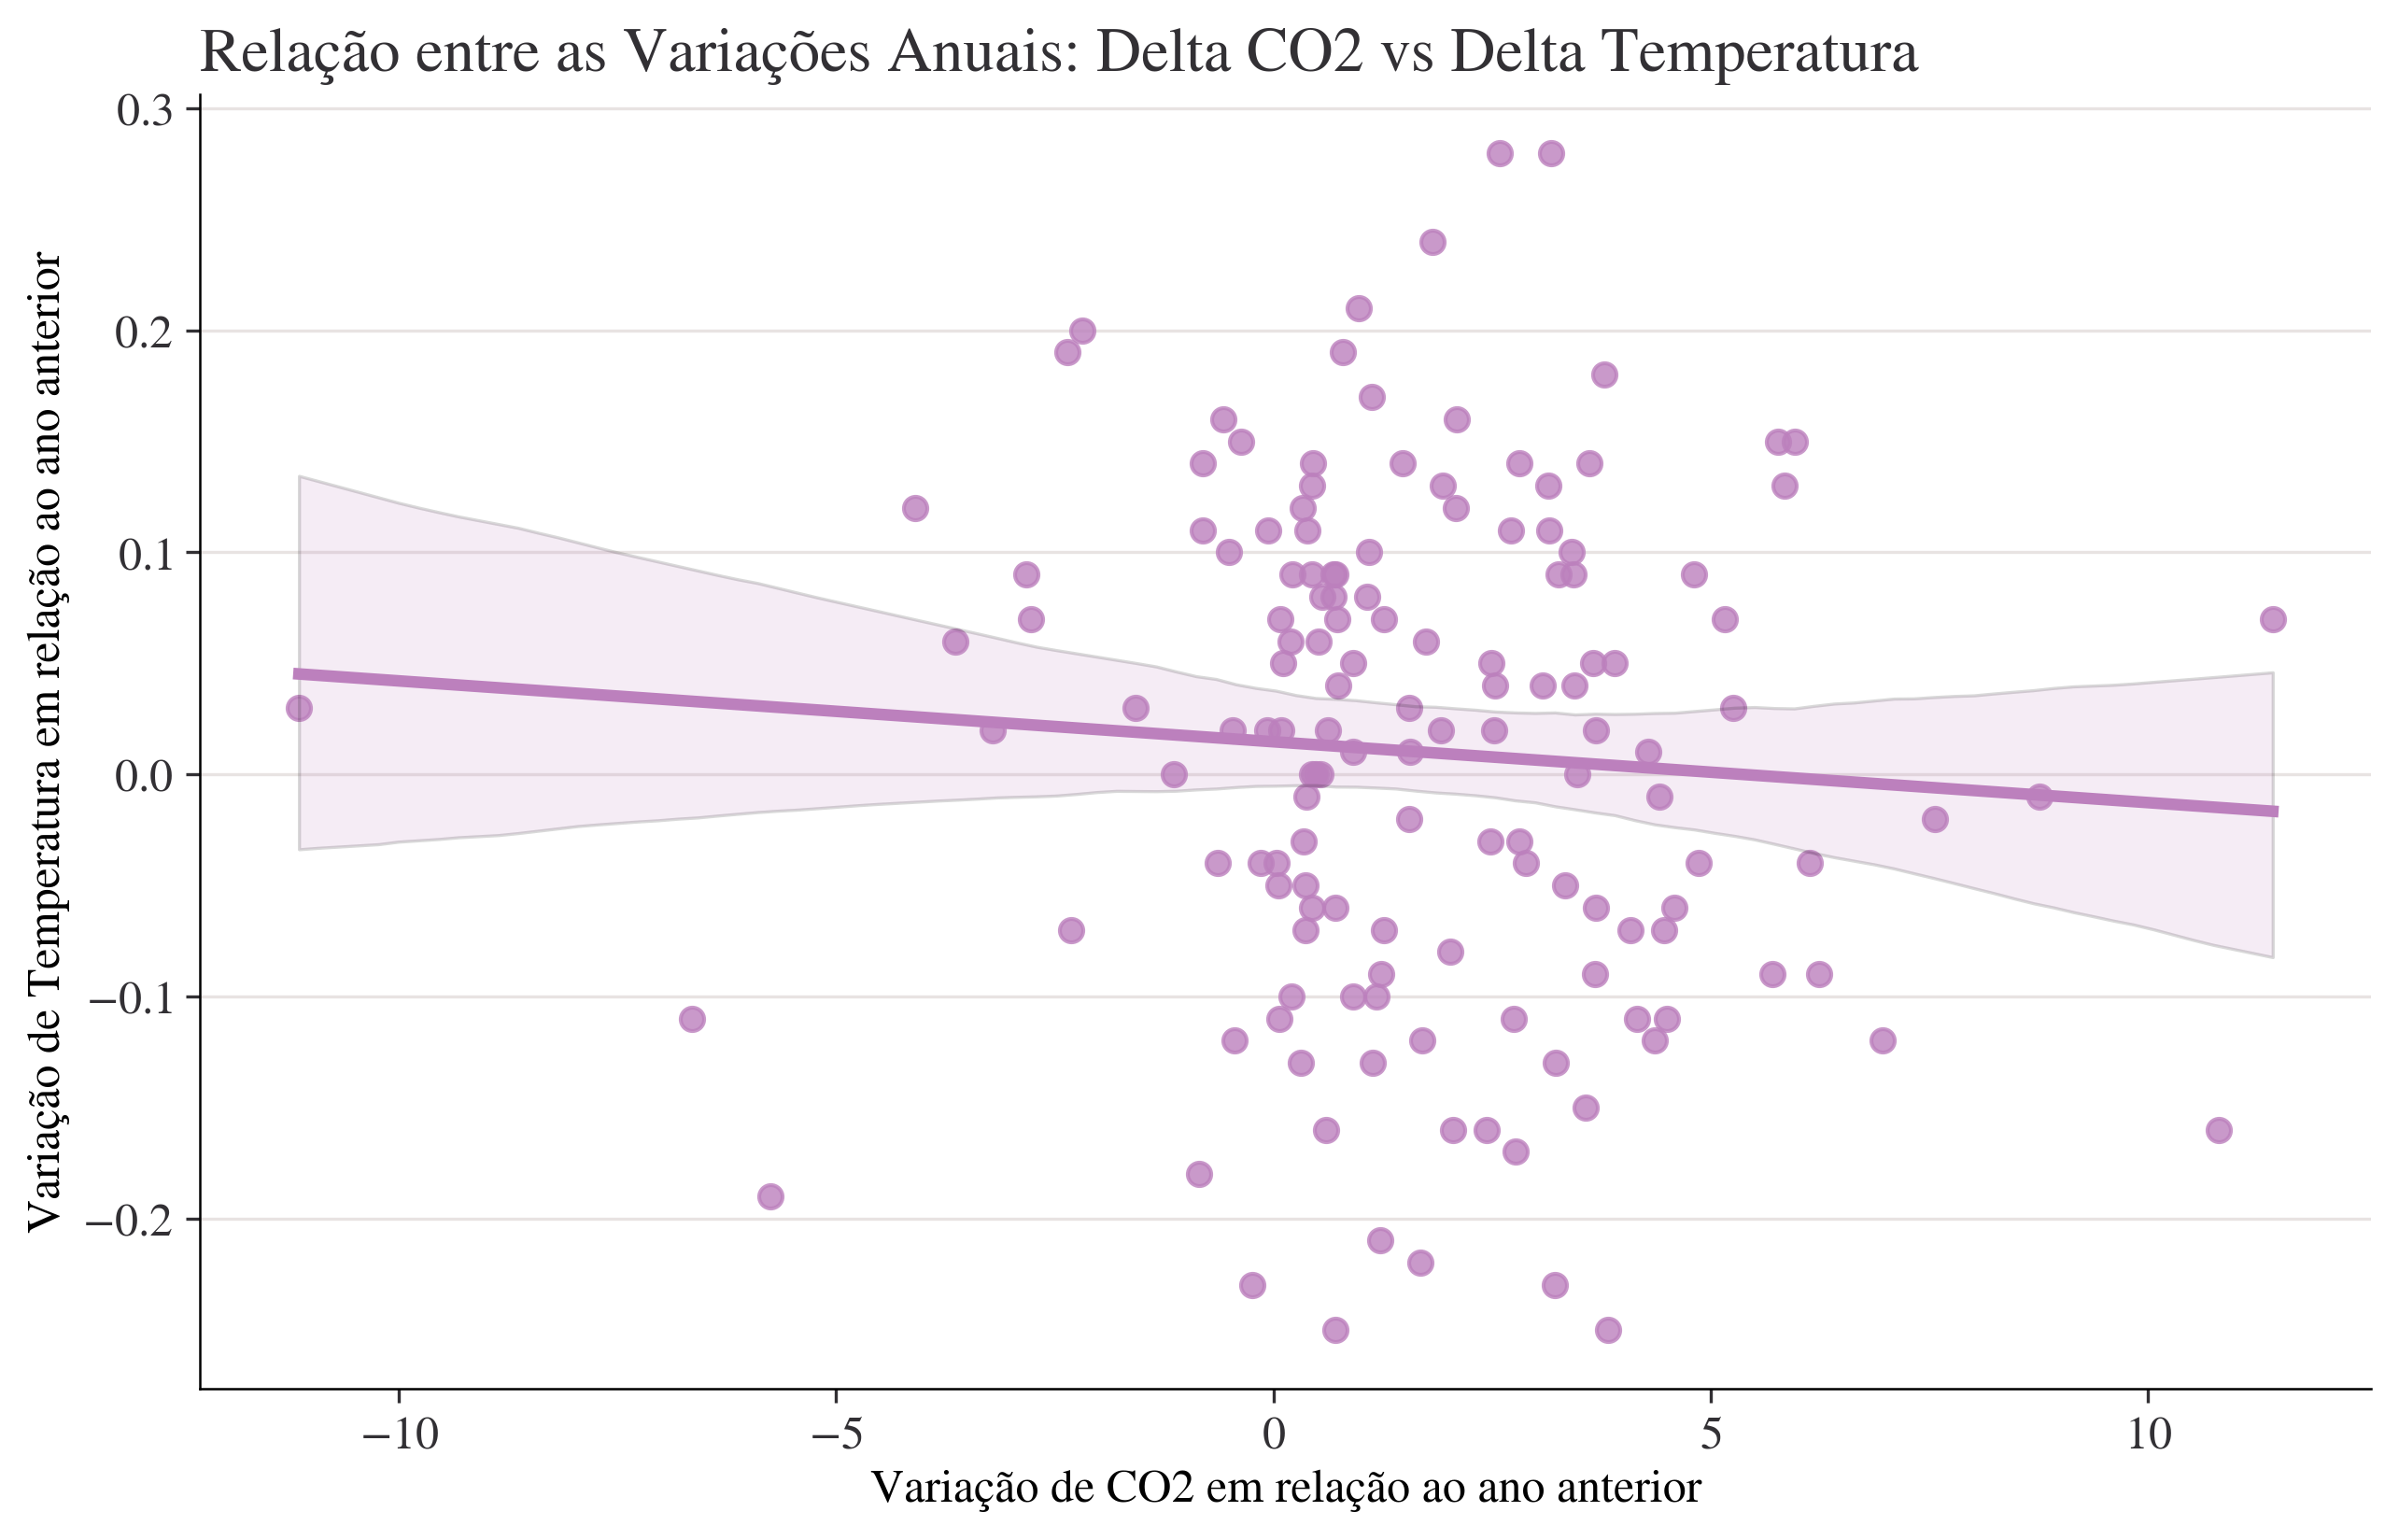

In [252]:
plt.figure(figsize=(10, 6))
sns.regplot(data=df_temp_co2, x='diff_co2', y='diff_temp')
plt.title("Relação entre as Variações Anuais: Delta CO2 vs Delta Temperatura")
plt.xlabel("Variação de CO2 em relação ao ano anterior")
plt.ylabel("Variação de Temperatura em relação ao ano anterior")
plt.show()

##5. Conclusões

É possível observar uma clara tendência de aumento na temperatura global a partir de 1980. Este fenómeno é transversal: todas as estações acompanharam esta subida. Desde esse ano, 95% dos meses situaram-se no quartil dos 70% mais quentes da série. A partir de 2011, o aquecimento intensificou-se, com os anos a registarem anomalias de cerca de +1°C, uma diferença drástica face ao período anterior, que se mantinha próximo da média de 0°C.
